## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [4]:
from nndl import Softmax

In [5]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [17]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples
loss = softmax.loss(X_train, y_train)

In [18]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:
(-ln(1/10)) ~ 2.3, which matched with other condition that hyperparameter is selected based on a random normal distribution ,which suggesting that the probability of choosing the right class is 1/10.

#### Softmax gradient

In [53]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.416730 analytic: -152.001995, relative error: 1.000000e+00
numerical: -1.466661 analytic: -122.891685, relative error: 9.764123e-01
numerical: 1.890070 analytic: 497.850786, relative error: 9.924358e-01
numerical: -1.964813 analytic: -650.753899, relative error: 9.939796e-01
numerical: -0.017156 analytic: -3.651316, relative error: 9.906469e-01
numerical: 4.216379 analytic: 615.073578, relative error: 9.863832e-01
numerical: -0.727139 analytic: -375.677835, relative error: 9.961364e-01
numerical: -0.475990 analytic: -278.439443, relative error: 9.965868e-01
numerical: 0.324697 analytic: -234.926397, relative error: 1.000000e+00
numerical: -2.159481 analytic: -710.929761, relative error: 9.939433e-01


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [36]:
import time

In [52]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))
# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3399396532921295 / 83371.71927783552 computed in 0.04289507865905762s
Vectorized loss / grad: 2.339939653292131 / 316.8047752766205 computed in 0.004729270935058594s
difference in loss / grad: -1.3322676295501878e-15 /83088.20086030144 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.3291304034860976
iteration 100 / 1500: loss 2.0616390907041193
iteration 200 / 1500: loss 2.051017981235304
iteration 300 / 1500: loss 1.9209935346386005
iteration 400 / 1500: loss 1.885435536823606
iteration 500 / 1500: loss 1.9814678707342335
iteration 600 / 1500: loss 1.8378308047921814
iteration 700 / 1500: loss 1.8765969806787177
iteration 800 / 1500: loss 1.8152856598420255
iteration 900 / 1500: loss 1.8351569354726087
iteration 1000 / 1500: loss 1.8449073046256754
iteration 1100 / 1500: loss 1.8155104716218375
iteration 1200 / 1500: loss 1.877802621063177
iteration 1300 / 1500: loss 1.7738122684068043
iteration 1400 / 1500: loss 1.840507445073996
That took 4.089767217636108s


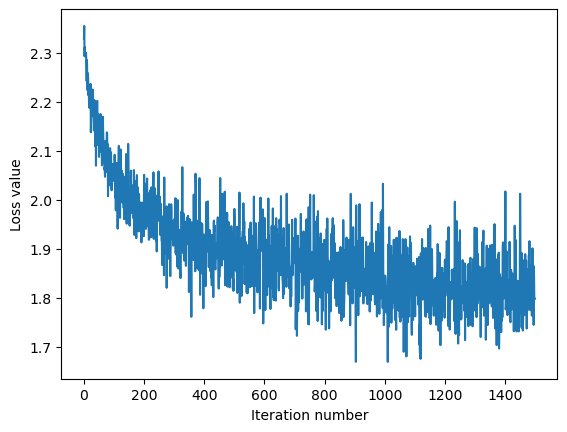

In [54]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [55]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3817755102040816
validation accuracy: 0.389


## Optimize the softmax classifier

In [56]:
np.finfo(float).eps

2.220446049250313e-16

In [59]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [1e-3, 1e-2, 1e-1, 1, 1e1]  # Example learning rates
best_lr = None
best_val_accuracy = 0
best_softmax = None

for lr in learning_rates:
    softmax = Softmax(dims=[num_classes, num_features])
    softmax.train(X_train, y_train, learning_rate=lr, num_iters=1000,
            batch_size=200, verbose=False) 

    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val_pred == y_val)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_lr = lr
        best_softmax = softmax

# Report best learning rate and validation accuracy
print("Best Learning Rate:", best_lr)
print("Best Validation Accuracy:", best_val_accuracy)
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
test_error_rate = 1 - test_accuracy
print("Test Error Rate:", test_error_rate)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Best Learning Rate: 0.01
Best Validation Accuracy: 0.316
Test Error Rate: 0.69
